<a href="https://colab.research.google.com/github/yashveersinghsohi/Car_Price_Prediction/blob/master/Feature_Engineering/CarPrice_03_Feature_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import (
    SelectKBest, 
    f_regression, 
    mutual_info_regression, 
    chi2, 
    RFE
  )

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data

In [2]:
root_dir = "https://raw.githubusercontent.com/yashveersinghsohi/Car_Price_Prediction/master/Data/Feature_Engineering_Data/"

train_features_path = root_dir + "train_features_df.csv"
train_targets_path = root_dir + "train_targets.csv"

val_features_path = root_dir + "val_features_df.csv"
val_targets_path = root_dir + "val_targets.csv"

In [3]:
train_features_df = pd.read_csv(train_features_path)
train_targets = pd.read_csv(train_targets_path)

val_features_df = pd.read_csv(val_features_path)
val_targets = pd.read_csv(val_targets_path)

print(f"Train Features: {train_features_df.shape}")
print(f"Train Targets: {train_targets.shape}", end="\n\n")

print(f"Validation Features: {val_features_df.shape}")
print(f"Validation Targets: {val_targets.shape}", end="\n\n")

Train Features: (13351, 30)
Train Targets: (13351, 1)

Validation Features: (3463, 30)
Validation Targets: (3463, 1)



# Feature Selection

## Scaling Data beforehand

A lot of the feature selection models use a linear regression estimator to judge feature performance, and linear regression is sensitive to feature scaling, it seems wise to perform feature scaling first

In [4]:
# Storing a copy of the data for future reference
train_features_df_og = train_features_df.copy()

# Scaling training data
scaler = StandardScaler()
train_features_df = pd.DataFrame(
    scaler.fit_transform(train_features_df), 
    columns=train_features_df_og.columns
  )
train_features_df.head()

,prod_year,prod_year_delta,prod_year_delta_sq,prod_year_delta_cu,prod_year_new,cylinders,airbags,levy,manufacturer_class,manufacturer_mean_le,manufacturer_median_le,category_mean_le,category_median_le,leather_interior,fuel_type_mean_le,fuel_type_median_le,turbo,engine_volume,mileage,mileage_new,gear_box_type_mean_le,gear_box_type_median_le,drive_wheels_mean_le,drive_wheels_median_le,doors_mean_le,doors_median_le,wheel_mean_le,wheel_median_le,color_mean_le,color_median_le
0,0.546706,-0.546706,-0.413618,-0.180715,-0.395587,-0.465299,0.333520,-1.889583,-1.682985,-0.103778,-0.103778,-1.172426,-1.172426,0.618251,-0.621684,-0.621684,-0.329841,-0.591048,0.581966,-0.194985,2.758510,2.758510,0.155798,0.155798,0.146126,0.146126,-0.28974,-0.28974,-0.150926,-0.150926
1,-2.336665,2.336665,2.011788,0.929791,1.098044,1.375083,-0.130099,-0.207690,0.406815,0.146139,0.146139,0.978655,0.978655,0.618251,-2.116392,-2.116392,-0.329841,1.266801,0.881675,-0.194985,1.641672,1.641672,1.953606,1.953606,0.146126,0.146126,-0.28974,-0.28974,-1.270687,-1.270687
2,-0.174137,0.174137,-0.067131,-0.097257,1.098044,-0.465299,-0.593717,-0.541935,-1.682985,-1.228401,-1.228401,0.978655,0.978655,0.618251,0.873023,0.873023,-0.329841,-0.856455,0.025364,-0.194985,-0.592006,-0.592006,0.155798,0.155798,0.146126,0.146126,-0.28974,-0.28974,-0.150926,-0.150926
3,-2.516876,2.516876,2.255412,1.091491,1.098044,-0.465299,-0.593717,-0.207690,0.406815,0.146139,0.146139,0.978655,0.978655,-1.617466,0.873023,0.873023,-0.329841,-0.325641,1.792845,-0.194985,0.524833,0.524833,1.953606,1.953606,0.146126,0.146126,-0.28974,-0.28974,-1.084060,-1.084060
4,0.907128,-0.907128,-0.521895,-0.196896,-1.142402,-0.465299,-0.593717,0.183448,0.406815,-0.541131,-0.541131,-0.813913,-0.813913,0.618251,-1.369038,-1.369038,-0.329841,-0.325641,-0.378034,-0.194985,-0.592006,-0.592006,0.155798,0.155798,0.146126,0.146126,-0.28974,-0.28974,1.155462,1.155462


## Using f_regression

`f_regression` measures the linear relationship features have with the target.

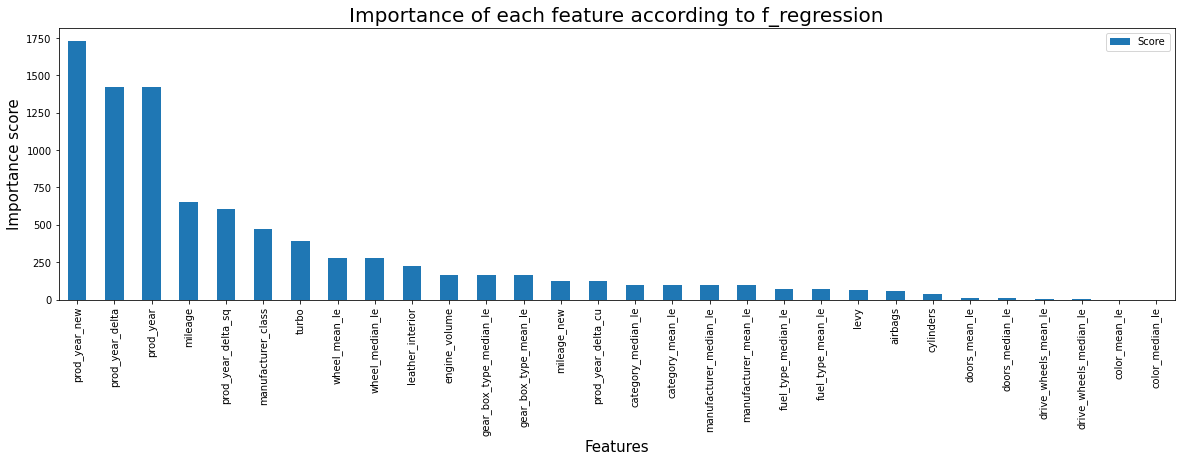

In [5]:
# Training f_regression model
X_train, y_train = train_features_df.to_numpy(), train_targets.to_numpy().ravel()

fs = SelectKBest(score_func=f_regression, k='all')
fs.fit(X_train, y_train)

# Storing f_regression scores
f_regression_df = pd.DataFrame(
    np.c_[train_features_df.columns, fs.scores_], 
    columns=["Feature", "Score"]
  )

# Plotting f_regression scores
fig, ax = plt.subplots(figsize=(20, 5))

f_regression_df.sort_values(
    by="Score", 
    ascending=False
  ).plot.bar(
      x="Feature", 
      y="Score", 
      ax=ax
    )
  
ax.tick_params('x', labelrotation=90)
ax.set_xlabel("Features", size=15)
ax.set_ylabel("Importance score", size=15)
ax.set_title("Importance of each feature according to f_regression", size=20)
plt.show()

## Using mutual_info_regression

`mutual_info_regression` measures the amount of information that can be expressed about the target using a feature.

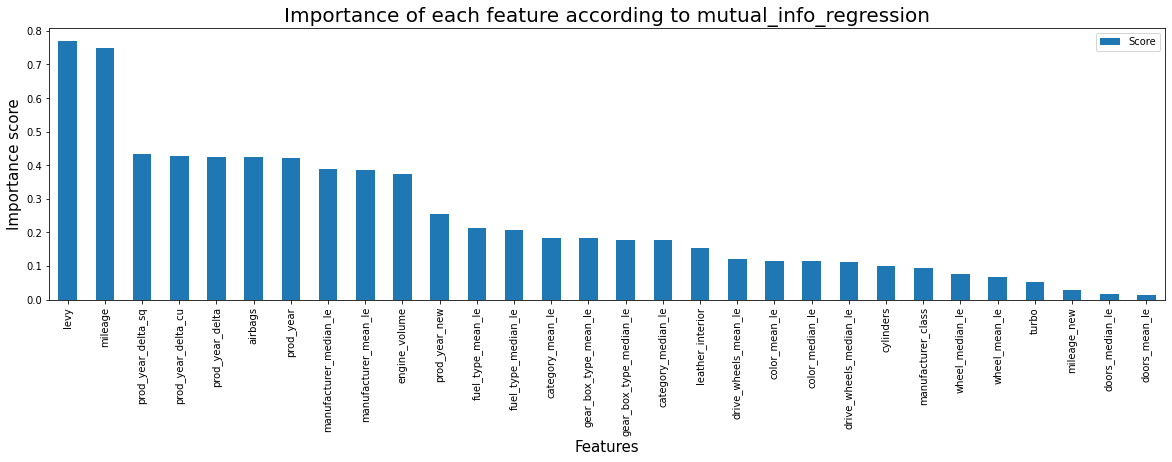

In [6]:
# Training mutual_info_regression model
X_train, y_train = train_features_df.to_numpy(), train_targets.to_numpy().ravel()

fs = SelectKBest(score_func=mutual_info_regression, k='all')
fs.fit(X_train, y_train)

# Storing mutual_info_regression scores
mutual_info_regression_df = pd.DataFrame(
    np.c_[train_features_df.columns, fs.scores_], 
    columns=["Feature", "Score"]
  )

# Plotting mutual_info_regression scores
fig, ax = plt.subplots(figsize=(20, 5))

mutual_info_regression_df.sort_values(
    by="Score", 
    ascending=False
  ).plot.bar(
      x="Feature", 
      y="Score", 
      ax=ax
    )
  
ax.tick_params('x', labelrotation=90)
ax.set_xlabel("Features", size=15)
ax.set_ylabel("Importance score", size=15)
ax.set_title("Importance of each feature according to mutual_info_regression", size=20)
plt.show()

## Using RFE (Recursive Feature Elimination) with linear regression estimator

RFE select features by recursively considering smaller and smaller sets of features.

In [7]:
X_train, y_train = train_features_df.to_numpy(), train_targets.to_numpy().ravel()

lin_reg = LinearRegression()

rfe = RFE(estimator=lin_reg, n_features_to_select=1, step=1)
rfe.fit(X_train, y_train)

rankings_map = {rank: col for rank, col in zip(rfe.ranking_, train_features_df.columns)}
rankings_list = [rankings_map[rank] for rank in sorted(rankings_map)]
lin_reg_rankings_df = pd.DataFrame(rankings_list, columns=["Feature"])
lin_reg_rankings_df

,Feature
0,prod_year
1,prod_year_delta
2,prod_year_delta_sq
3,prod_year_delta_cu
4,gear_box_type_median_le
5,gear_box_type_mean_le
6,airbags
7,engine_volume
8,fuel_type_median_le
9,category_mean_le


## Using p-value from OLS regression in statsmodels

`p-vlaue` from `OLS` regression in `statsmodels` can tell us whether adding a certain feature is making the model better or not

In [8]:
X_train, y_train = train_features_df, train_targets.to_numpy().ravel()
X_train = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     298.6
Date:                Fri, 10 Sep 2021   Prob (F-statistic):               0.00
Time:                        23:35:29   Log-Likelihood:            -1.4521e+05
No. Observations:               13351   AIC:                         2.905e+05
Df Residuals:                   13329   BIC:                         2.906e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1.644e+04    110.876    148.255      0.000    1.62e+04    1.67e+04
prod_year                7117.9987    630.505     11.289      0.000    5882.120    8353.877
prod_year_delta         -7117.9987    630.505    -11.289      0.000   -8353.877   -5882.120
prod_year_delta_sq       1.429e+04   1593.336      8.969      0.000    1.12e+04    1.74e+04
prod_year_delta_cu      -6084.5545    784.336     -7.758      0.000   -7621.964   -4547.144
prod_year_new            -385.8819    392.923     -0.982      0.326   -1156.067     384.303
cylinders                -458.9397    177.053     -2.592      0.010    -805.988    -111.891
airbags                 -3398.2225    125.435    -27.091      0.000   -3644.094   -3152.351
levy                      136.3706    140.162      0.973      0.331    -138.366     411.107
manufacturer_class       1963.7006    125.461     15.652      0.000    1717.779    2209.622
manufacturer_mean_le     -191.6914     59.862     -3.202      0.001    -309.029     -74.354
manufacturer_median_le   -191.6914     59.862     -3.202      0.001    -309.029     -74.354
category_mean_le         -915.0072     61.137    -14.967      0.000   -1034.844    -795.170
category_median_le       -915.0072     61.137    -14.967      0.000   -1034.844    -795.170
leather_interior           40.8878    139.153      0.294      0.769    -231.872     313.648
fuel_type_mean_le        -570.0920     60.355     -9.446      0.000    -688.397    -451.787
fuel_type_median_le      -570.0920     60.355     -9.446      0.000    -688.397    -451.787
turbo                    2604.8115    117.209     22.224      0.000    2375.065    2834.558
engine_volume            3608.4659    203.074     17.769      0.000    3210.411    4006.520
mileage                 -2611.6060    128.272    -20.360      0.000   -2863.037   -2360.175
mileage_new             -1619.0630    119.451    -13.554      0.000   -1853.204   -1384.922
gear_box_type_mean_le    1591.7811     62.380     25.518      0.000    1469.508    1714.055
gear_box_type_median_le  1591.7811     62.380     25.518      0.000    1469.508    1714.055
drive_wheels_mean_le       59.0325     63.257      0.933      0.351     -64.960     183.025
drive_wheels_median_le     59.0325     63.257      0.933      0.351     -64.960     183.025
doors_mean_le             237.3774     59.281      4.004      0.000     121.179     353.576
doors_median_le           237.3774     59.281      4.004      0.000     121.179     353.576
wheel_mean_le            -193.6917     64.496     -3.003      0.003    -320.112     -67.271
wheel_median_le          -193.6917     64.496     -3.003      0.003    -320.112     -67.271
color_mean_le              78.7346     56.388      1.396      0.163     -31.794     189.263
color_median_le            78.7346     56.388  

## Using feature importance in RandomForest

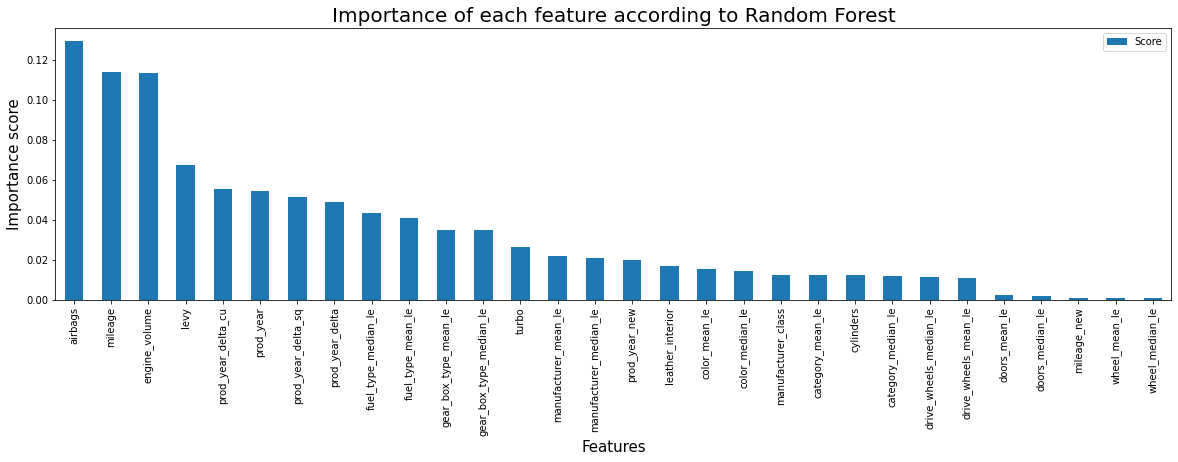

In [9]:
X_train, y_train = train_features_df, train_targets.to_numpy().ravel()

rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train)

rf_reg_df = pd.DataFrame(
    np.c_[train_features_df.columns, rf_reg.feature_importances_], 
    columns=["Feature", "Score"]
  )

fig, ax = plt.subplots(figsize=(20, 5))

rf_reg_df.sort_values(
    by="Score", 
    ascending=False
  ).plot.bar(
      x="Feature", 
      y="Score", 
      ax=ax
    )
  
ax.tick_params('x', labelrotation=90)
ax.set_xlabel("Features", size=15)
ax.set_ylabel("Importance score", size=15)
ax.set_title("Importance of each feature according to Random Forest", size=20)
plt.show()

# Feature pruning

After studying all the plots, and the RFE rankings I decided to remove the following features:
- All Median label encoded (`...median_le`) features.
  - This is because in all cases the Mean label encoded (`...mean_le`) counterparts are looking better or roughly the same.

- `color`, `drive_wheels`, `doors`
  - Seem unimportant according to all the tests

- `prod_year_new`
  - Intended to capture the same information as `mileage_new`, but the latter is performing better across all tests.

In [10]:
features_to_keep = [
    "prod_year", "prod_year_delta", 
    "prod_year_delta_sq", "prod_year_delta_cu", 
    "cylinders", "airbags", "levy", 
    "manufacturer_class", "manufacturer_mean_le", 
    "category_mean_le", "leather_interior", 
    "fuel_type_mean_le", "turbo", "engine_volume", 
    "mileage", "mileage_new", 
    "gear_box_type_mean_le", "wheel_mean_le"
]
len(features_to_keep)

18

# Exporting Pruned features

In [11]:
# train_features_df_og[features_to_keep].to_csv("pruned_train_features.csv", index=False)
# val_features_df[features_to_keep].to_csv("pruned_val_features.csv", index=False)